In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow_datasets as tfds

In [ ]:
from tensorflow.keras.layers import Conv2D, InputLayer, MaxPool2D, Dense, Flatten, BatchNormalization

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

# Loading Malaria Dataset
















There are 2 ways of doing this:

1. Using Kaggle dataset.
2. Using TensorFlow dataset

Right now, I'll be using TensorFlow dataset because it'll be faster and more efficient to implement.

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True,
                                  shuffle_files = True,
                                  split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete8UN0IF/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

# Creating Splitting function for the dataset

In [ ]:
def data_split(dataset, train_ratio, test_ratio, validation_ratio):
  dataset_size = len(dataset)
  train_dataset = dataset.take(int(train_ratio*dataset_size))

  val_test_dataset = dataset.skip(int(train_ratio*dataset_size))
  val_dataset = val_test_dataset.take(int(validation_ratio*dataset_size))

  test_dataset = val_test_dataset.skip(int(validation_ratio*dataset_size))

  return train_dataset, val_dataset, test_dataset


In [ ]:
TRAIN_RATIO =0.6
TEST_RATIO=0.2
VALIDATION_RATIO=0.2

train_dataset, val_dataset, test_dataset = data_split(dataset[0], TRAIN_RATIO, TEST_RATIO, VALIDATION_RATIO)



# Visualization

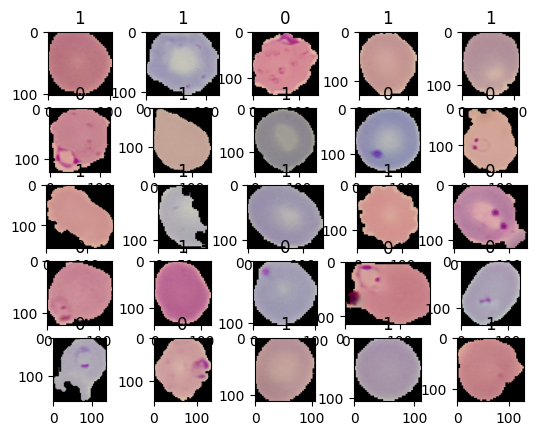

In [ ]:
for i, (image,label) in enumerate(train_dataset.take(25)):
  plt.subplot(5,5,i+1)
  plt.imshow(image)
  plt.title(label.numpy())


This image shows that where the cell is *infected*, the label is 0. While, if the cell is *not infected*, the label is 1. The labels have been displayed on top of the respective images.

# Data Preprocessing

Although the dataset is balanced, it'll still be good if we apply some preprocessing to make it more efficient.
We will be employing following preprocessing techniques:
1. Image Resizing
2. Data Normalization: Having data in normalized form provides us with the data in a particular range which makes the model performance better than unnormalized data.

In [ ]:
IMAGE_SIZE =224

def img_resize(image,label):
  image = tf.image.resize(image, (IMAGE_SIZE,IMAGE_SIZE))/255.0
  return image, label



In [ ]:
train_dataset = train_dataset.map(img_resize)
val_dataset = val_dataset.map(img_resize)
test_dataset = test_dataset.map(img_resize)

In [ ]:
#checking our resized dataset
for image,label in train_dataset.take(1):
  print(image.shape)
  print(label)

(224, 224, 3)
tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

# Model Creation

In [ ]:
model = tf.keras.Sequential([
  InputLayer(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)),

  tf.keras.layers.Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
  BatchNormalization(),
  MaxPool2D(pool_size=2, strides=2),

  tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
  BatchNormalization(),
  MaxPool2D(pool_size=2, strides=2),

  Flatten(),

  Dense(1000, activation='relu'),
  BatchNormalization(),

  Dense(100, activation='relu'),
  BatchNormalization(),

  Dense(1,  activation='sigmoid')

])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [29]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=BinaryCrossentropy(), metrics=['accuracy'])

In [30]:
history= model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
517/517 [==============================] - 42s 76ms/step - loss: 0.0165 - accuracy: 0.9945 - val_loss: 10.5331 - val_accuracy: 0.9325
Epoch 2/20
517/517 [==============================] - 45s 87ms/step - loss: 0.0089 - accuracy: 0.9973 - val_loss: 9.7352 - val_accuracy: 0.9345
Epoch 3/20
517/517 [==============================] - 39s 75ms/step - loss: 0.0090 - accuracy: 0.9970 - val_loss: 10.6451 - val_accuracy: 0.9329
Epoch 4/20
517/517 [==============================] - 46s 89ms/step - loss: 0.0075 - accuracy: 0.9976 - val_loss: 8.6099 - val_accuracy: 0.9343
Epoch 5/20
517/517 [==============================] - 46s 89ms/step - loss: 0.0081 - accuracy: 0.9977 - val_loss: 3.3302 - val_accuracy: 0.9287
Epoch 6/20
517/517 [==============================] - 39s 75ms/step - loss: 0.0094 - accuracy: 0.9964 - val_loss: 8.3868 - val_accuracy: 0.9338
Epoch 7/20
517/517 [==============================] - 39s 75ms/step - loss: 0.0061 - accuracy: 0.9984 - val_loss: 11.7297 - val_accura

# Visually Checking the Model Accuracy

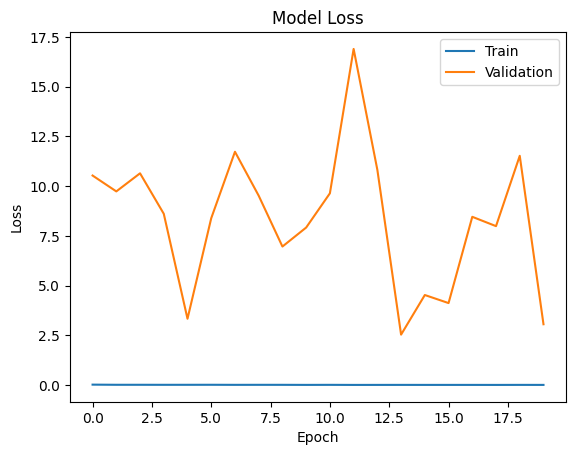

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

This shows that training dataset loss remains nearly constant but there is significant drop in validation loss i.e model gets better.

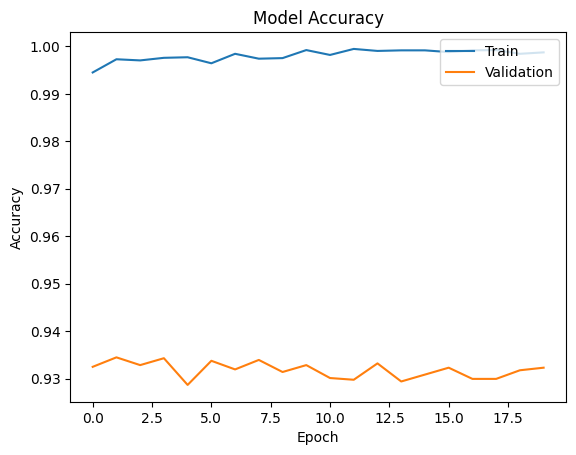

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

This shows that validation dataset accuracy shows certain spikes but gets better eventually

# Model Evaluation

In [ ]:
test_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
test_dataset = test_dataset.batch(1)

In [28]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [33]:
model.evaluate(test_dataset)

5513/5513 [==============================] - 33s 4ms/step - loss: 24.1765 - accuracy: 0.9342


[24.17648696899414, 0.9341556429862976]